# Úvod

FordA dataset je jednou z populárních časových řad využívaných v oblasti strojového učení, konkrétně v klasifikaci
časových řad. Tento dataset obsahuje data o průmyslové výrobě v USA v období od ledna 1985 do prosince 1989. Data jsou
měsíční, což znamená, že celkově dataset obsahuje 96 pozorování.

Hlavním cílem analýzy tohoto datasetu je predikce trendů v průmyslové výrobě na základě historických dat.

V následujících sekcích se podrobněji podíváme na strukturu datasetu, metody analýzy a výsledky, které lze dosáhnout při
jeho zpracování.


# Načtení všech knihoven


In [1]:
import os
import zipfile
import copy
from collections import defaultdict

import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Kontrola dostupnosti GPU


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

GPU: NVIDIA GeForce RTX 2070


# Načtení dat


## Stažení a extrakce dat


In [3]:
dataset_path = "../../datasets/FordA/"
url = "https://www.timeseriesclassification.com/aeon-toolkit/FordA.zip"
zip_file_name = "FordA.zip"

In [4]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

    print(f"Downloading dataset from {url}...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024

    zip_path = os.path.join(dataset_path, zip_file_name)
    with open(zip_path, "wb") as f:
        progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading")
        for data in response.iter_content(block_size):
            f.write(data)
            progress_bar.update(len(data))

    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        for file in tqdm(file_list, desc="Extracting"):
            zip_ref.extract(file, dataset_path)

    # Remove zip file
    os.remove(zip_path)
    print("Download and extraction complete!")
else:
    print(f"Dataset already exists at {dataset_path}")

Dataset already exists at ../../datasets/FordA/


## Načtení dat do pandas DataFrame


In [5]:
train_arff_path = "../../datasets/FordA/FordA_TRAIN.arff"
test_arff_path = "../../datasets/FordA/FordA_TEST.arff"

### Načtení ARFF souborů


In [6]:
arff_train_file, _ = arff.loadarff(train_arff_path)
arff_test_file, _ = arff.loadarff(test_arff_path)

In [7]:
df_train = pd.DataFrame(arff_train_file)
df_test = pd.DataFrame(arff_test_file)

# Zobrazení dat


## Velikost dat


In [8]:
print(f"Train: {df_train.shape}\nTest: {df_test.shape}")

Train: (3601, 501)
Test: (1320, 501)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 13.8+ MB


In [10]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,b'-1'
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,b'1'
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,b'-1'
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,b'-1'
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,b'-1'


## Převod dat na číselný formát

Nyní máme cílovou proměnnou ve formátu _bytes_, tak si jej převedeme na _int_.


In [11]:
df_train['target'] = df_train['target'].astype(int)
df_test['target'] = df_test['target'].astype(int)

## Medián


In [12]:
df_train.groupby('target').mean()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
-1,-0.014895,-0.015515,-0.016355,-0.016704,-0.015422,-0.011477,-0.006306,-0.001435,0.002810,0.004730,...,0.020576,0.014972,0.006110,-0.003215,-0.010949,-0.014388,-0.012541,-0.006267,0.002245,0.010434
1,-0.018616,-0.015013,-0.010712,-0.006936,-0.004227,-0.002419,-0.000538,0.002675,0.008029,0.015609,...,-0.003742,-0.001601,0.001889,0.005288,0.007573,0.008220,0.006549,0.002857,-0.002297,-0.008113


## Směrodatná odchylka


In [13]:
df_train.groupby('target').std()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
-1,1.046503,1.038535,1.030145,1.031180,1.041815,1.051984,1.053741,1.048960,1.042726,1.03680,...,1.037209,1.037731,1.034531,1.025603,1.011854,0.997298,0.987655,0.990511,1.007039,1.028501
1,1.071179,1.066081,1.059798,1.054695,1.052556,1.053998,1.057515,1.060192,1.058752,1.05203,...,1.038403,1.043903,1.047698,1.048433,1.045641,1.040933,1.036925,1.035120,1.035589,1.036879


### Rovnováha tříd


In [14]:
df_train.target.value_counts()

target
-1    1846
 1    1755
Name: count, dtype: int64

In [15]:
df_test.target.value_counts()

target
-1    681
 1    639
Name: count, dtype: int64

## Vizualizace dat


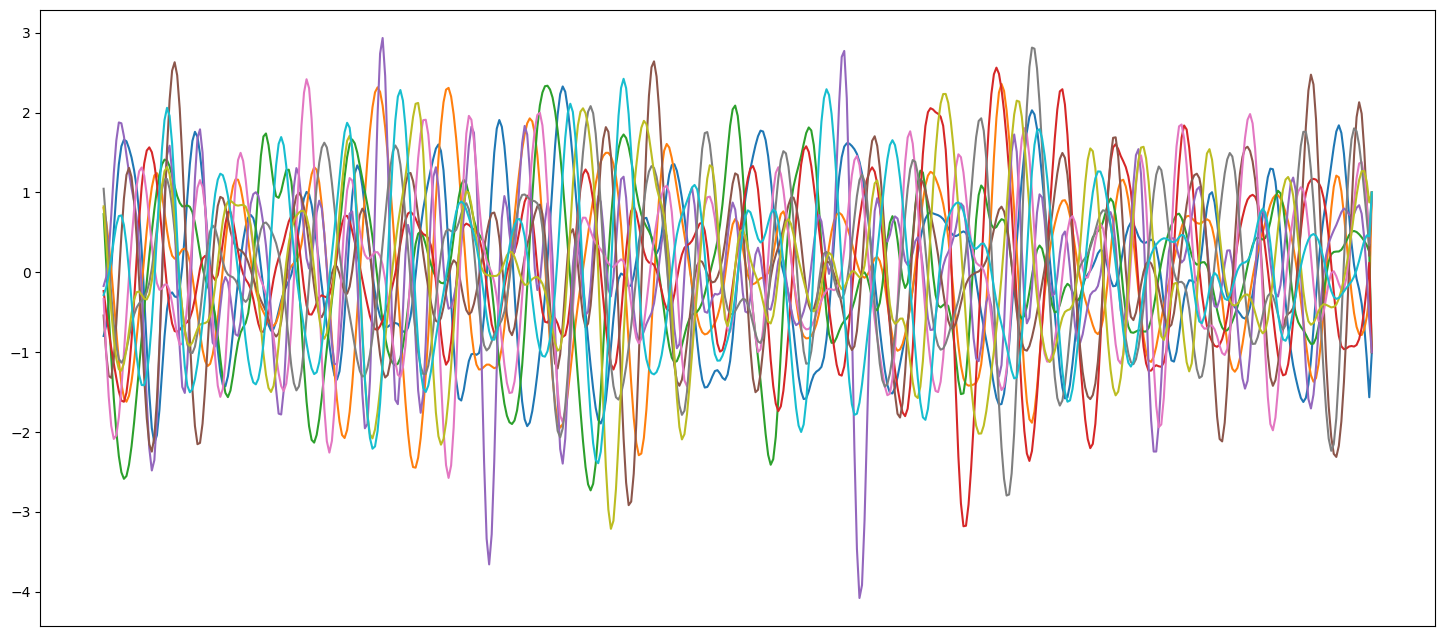

In [16]:
plt.figure(figsize=(18, 8))
for idx in range(10):
    plt.plot(df_train.iloc[idx, :])
plt.xticks([])
plt.show()

# Příprava dat


In [17]:
x_train = df_train.drop(columns='target').values
y_train = df_train.target.values
x_test = df_test.drop(columns='target').values
y_test = df_test.target.values

## Převod dat na číselný formát


In [18]:
df_train['target'] = df_train['target'].astype(int)
df_test['target'] = df_test['target'].astype(int)

In [19]:
print("Unique values in Y_train:", np.unique(y_train))
print("Unique values in Y_test:", np.unique(y_test))

Unique values in Y_train: [-1  1]
Unique values in Y_test: [-1  1]


## Mapování tříd


In [20]:
df_train['target'] = df_train['target'].replace({-1: 0, 1: 1})
df_test['target'] = df_test['target'].replace({-1: 0, 1: 1})

### Aktualizace hodnot


In [21]:
y_train = df_train['target'].values
y_test = df_test['target'].values

In [22]:
print("Unique values in Y_train:", np.unique(y_train))
print("Unique values in Y_test:", np.unique(y_test))

Unique values in Y_train: [0 1]
Unique values in Y_test: [0 1]


## Rozdělení dat na trénovací a testovací


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Klasifikace pomocí základních metod


## Decision Tree


In [24]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [25]:
y_test_predictions_dt = dt.predict(X_test)
print(classification_report(Y_test, y_test_predictions_dt))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59       373
           1       0.56      0.56      0.56       348

    accuracy                           0.58       721
   macro avg       0.58      0.58      0.58       721
weighted avg       0.58      0.58      0.58       721



## Random Forest


In [26]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_test_predictions_rf = rf.predict(X_test)
print(classification_report(Y_test, y_test_predictions_rf))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       373
           1       0.71      0.70      0.70       348

    accuracy                           0.71       721
   macro avg       0.71      0.71      0.71       721
weighted avg       0.71      0.71      0.71       721



## Gradient Boosting


In [28]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

In [29]:
y_test_predictions_gb = gb.predict(X_test)
print(classification_report(Y_test, y_test_predictions_gb))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65       373
           1       0.62      0.58      0.60       348

    accuracy                           0.62       721
   macro avg       0.62      0.62      0.62       721
weighted avg       0.62      0.62      0.62       721



# Klasifikace pomocí neuronových sítí


### Příprava dat pro trénování


In [30]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

In [31]:
# Reshape the tensors to have the correct format for Conv1d layers [batch, channels, seq_len]
X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape becomes [batch, 1, seq_len]
X_test_tensor = X_test_tensor.unsqueeze(1)  # Shape becomes [batch, 1, seq_len]

In [32]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [33]:
print(X_train_tensor.shape)

torch.Size([2880, 1, 500])


#### Trénovací parametry


In [34]:
batch_size = 64
num_epochs = 50
learning_rate = 0.001
class_names = ['0', '1']
num_classes = len(torch.unique(Y_train_tensor))

#### DataLoader


In [35]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Pomocné funkce


#### Funkce pro trénování modelu


In [36]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Print header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc':<10} | Improvement")
    print("-" * 50)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_samples = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += inputs.size(0)

        # Calculate metrics
        epoch_loss = train_loss / total_samples
        epoch_acc = train_correct / total_samples
        
        # Store metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Check for improvement
        improvement = ""
        if epoch_acc > best_acc:
            improvement = "✓"
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())            

        print(f"{epoch + 1:>3}/{num_epochs:<3} | {epoch_loss:>10.4f} | {epoch_acc:>9.2%} | {improvement}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete! Best accuracy: {best_acc:.2%}")

    return model, history

#### Funkce pro vykreslení historie trénování


In [78]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Trénovací ztráta')
    plt.xlabel('Epoch')
    plt.ylabel('Ztráta')
    plt.legend()
    plt.title('Ztráta během epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Trénovací přesnost')
    plt.xlabel('Epocha')
    plt.ylabel('Přesnost')
    plt.legend()
    plt.title('Přesnost během epoch')

    plt.tight_layout()
    plt.show()


#### Funkce pro vyhodnocení modelu


In [ ]:
def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        digits=4,
        zero_division=1,
        output_dict=True
    )

    # Print results
    print(f"\n{' Test Results ':=^40}")
    print(f"Overall Accuracy: {accuracy:.2%}\n")
    print("Classification Report:")
    # Set zero_division=1 here as well
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4, zero_division=1))

    # Plot confusion matrix if class_names are provided
    if class_names:
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Return metrics dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    }

    return metrics

### Trénování jednotlivých modelů


#### RNN


In [39]:
class RNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(RNNModel, self).__init__()
        
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # RNN Temporal Processor
        self.rnn = nn.RNN(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            nonlinearity='relu'
        )
        
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    
    def forward(self, x):
        # Check input dimensions and fix if needed
        # Expected shape: [batch, channels, seq_len]
        if x.size(1) != 1:
            x = x.permute(0, 2, 1)  # Convert from [batch, seq_len, channels] to [batch, channels, seq_len]
        
        # CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove the last dimension
        
        # RNN Processing - add a sequence dimension
        cnn_features = cnn_features.unsqueeze(1)  # [batch, 1, features]
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 2 layers
        rnn_out, _ = self.rnn(cnn_features, h0)
        rnn_features = rnn_out[:, -1, :]  # Last timestep
        
        # Classification
        logits = self.classifier(rnn_features)
        return logits

In [40]:
input_size = 1
hidden_size = 64
num_layers = 3
dropout = 0.5

In [41]:
model = RNNModel(input_size, num_classes).to(device)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
rnn_model, rnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.5080 |    71.70% | ✓
  2/50  |     0.3145 |    85.42% | ✓
  3/50  |     0.2719 |    88.61% | ✓
  4/50  |     0.2507 |    90.24% | ✓
  5/50  |     0.2425 |    89.93% | 
  6/50  |     0.2238 |    91.11% | ✓
  7/50  |     0.2129 |    92.01% | ✓
  8/50  |     0.2004 |    92.36% | ✓
  9/50  |     0.2016 |    92.36% | 
 10/50  |     0.1944 |    92.33% | 
 11/50  |     0.1964 |    92.29% | 
 12/50  |     0.1873 |    92.99% | ✓
 13/50  |     0.1875 |    93.06% | ✓
 14/50  |     0.1783 |    93.75% | ✓
 15/50  |     0.1613 |    93.89% | ✓
 16/50  |     0.1768 |    93.61% | 
 17/50  |     0.1855 |    92.78% | 
 18/50  |     0.1656 |    93.75% | 
 19/50  |     0.1780 |    93.44% | 
 20/50  |     0.1602 |    94.10% | ✓
 21/50  |     0.1662 |    93.37% | 
 22/50  |     0.1636 |    93.78% | 
 23/50  |     0.1797 |    92.74% | 
 24/50  |     0.1439 |    94.69% | ✓
 25/50  |     0.1418 |

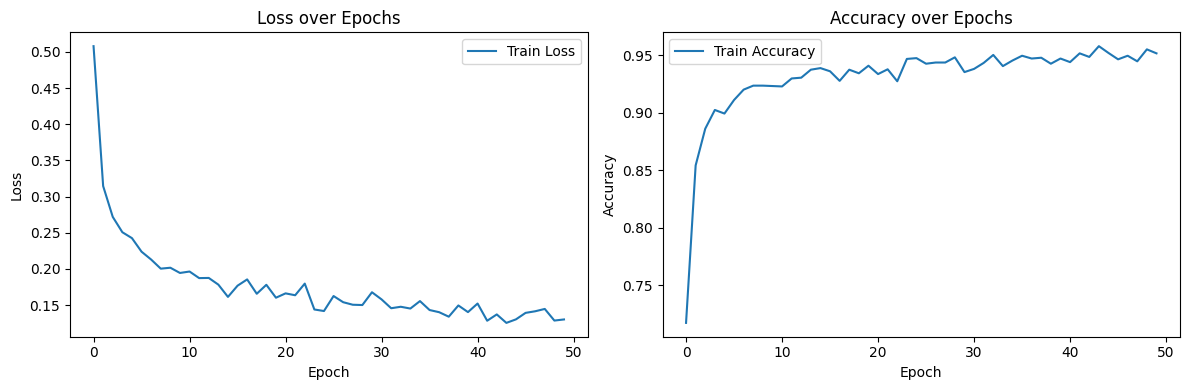

In [44]:
plot_training_history(rnn_history)


============= Test Results =============
Overall Accuracy: 94.04%

Classification Report:
              precision    recall  f1-score   support

           0     0.9661    0.9169    0.9409       373
           1     0.9155    0.9655    0.9399       348

    accuracy                         0.9404       721
   macro avg     0.9408    0.9412    0.9404       721
weighted avg     0.9417    0.9404    0.9404       721



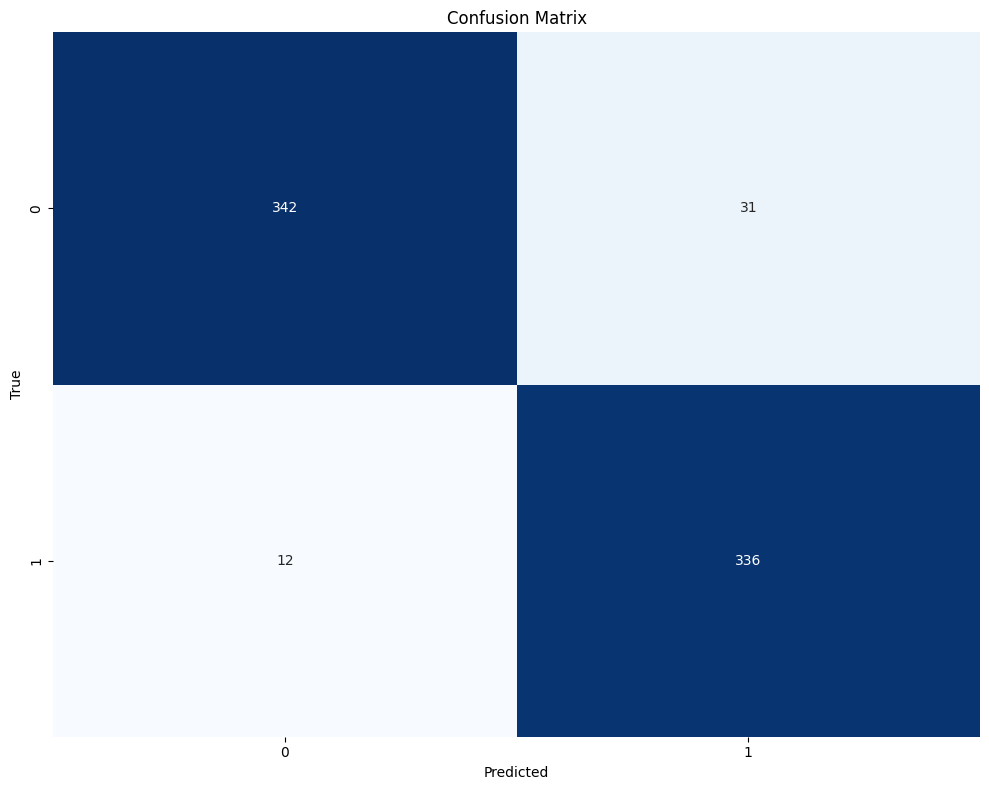

In [45]:
rnn_metrics = evaluate_model(rnn_model, test_loader, device, class_names)

#### GRU


In [46]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(GRUModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. GRU Temporal Processor
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),

            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        # Check input dimensions and fix if needed
        # Expected shape: [batch, channels, seq_len]
        if x.size(1) != 1:
            x = x.permute(0, 2, 1)  # Convert from [batch, seq_len, channels] to [batch, channels, seq_len]
        
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for GRU (add sequence dimension back)
        gru_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. GRU Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        gru_out, _ = self.gru(gru_input, h0)
        gru_out = gru_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(gru_out)
        return logits

In [47]:
model = GRUModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
gru_model, gru_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.5210 |    72.95% | ✓
  2/50  |     0.3306 |    85.90% | ✓
  3/50  |     0.2739 |    89.20% | ✓
  4/50  |     0.2646 |    89.24% | ✓
  5/50  |     0.2371 |    90.94% | ✓
  6/50  |     0.2295 |    91.39% | ✓
  7/50  |     0.2134 |    91.63% | ✓
  8/50  |     0.2187 |    91.84% | ✓
  9/50  |     0.2299 |    90.62% | 
 10/50  |     0.2038 |    92.08% | ✓
 11/50  |     0.1986 |    92.33% | ✓
 12/50  |     0.2077 |    91.56% | 
 13/50  |     0.2100 |    91.70% | 
 14/50  |     0.1938 |    92.50% | ✓
 15/50  |     0.2137 |    91.77% | 
 16/50  |     0.1778 |    93.65% | ✓
 17/50  |     0.1891 |    92.33% | 
 18/50  |     0.1837 |    92.85% | 
 19/50  |     0.1912 |    92.99% | 
 20/50  |     0.1813 |    92.92% | 
 21/50  |     0.1744 |    93.51% | 
 22/50  |     0.1769 |    93.02% | 
 23/50  |     0.1664 |    94.13% | ✓
 24/50  |     0.1808 |    92.74% | 
 25/50  |     0.1782 |

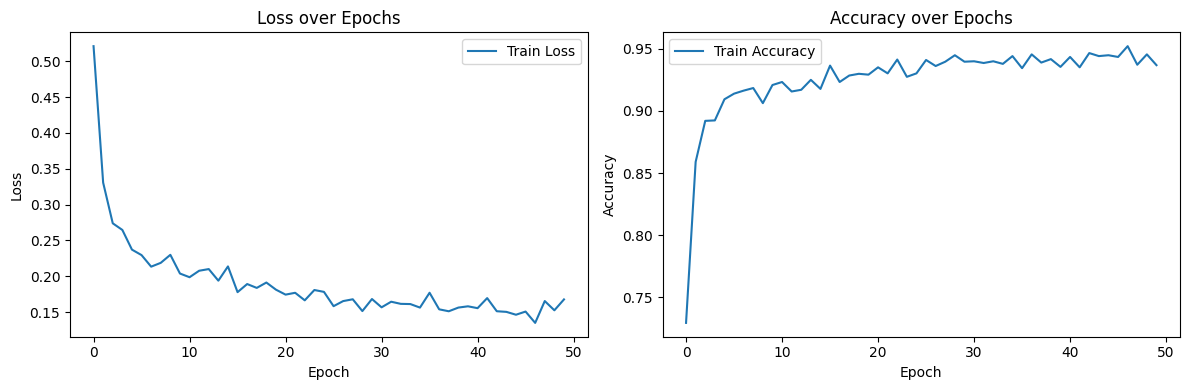

In [50]:
plot_training_history(gru_history)


============= Test Results =============
Overall Accuracy: 93.90%

Classification Report:
              precision    recall  f1-score   support

           0     0.9410    0.9410    0.9410       373
           1     0.9368    0.9368    0.9368       348

    accuracy                         0.9390       721
   macro avg     0.9389    0.9389    0.9389       721
weighted avg     0.9390    0.9390    0.9390       721



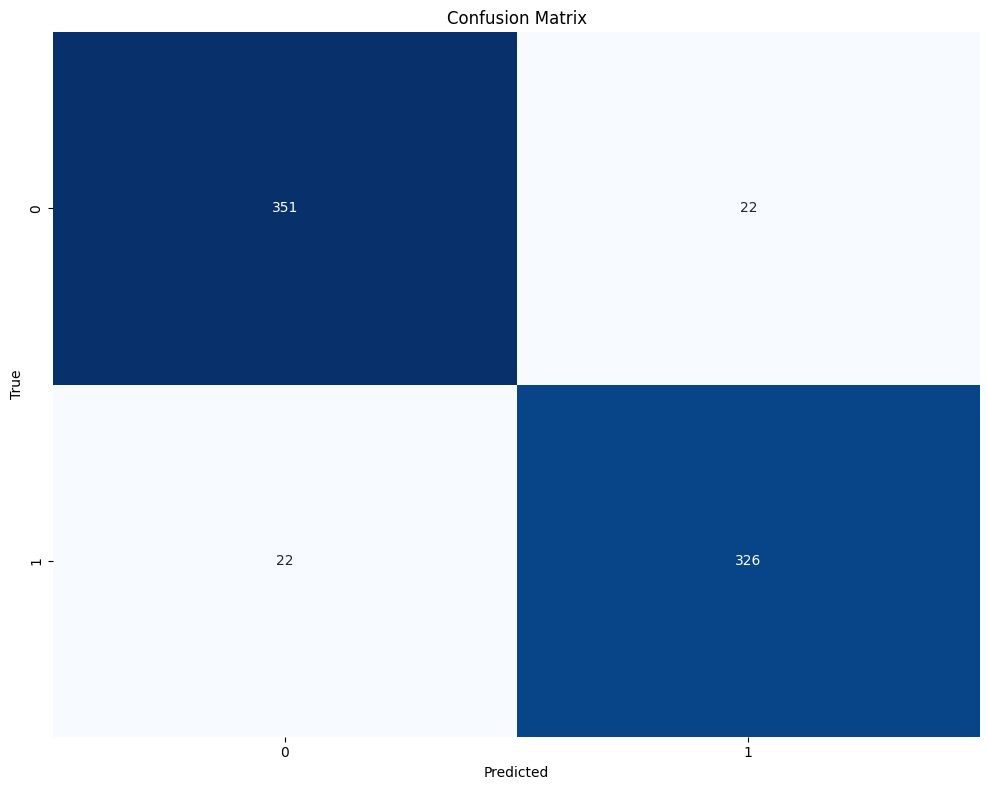

In [51]:
gru_metrics = evaluate_model(gru_model, test_loader, device, class_names)

#### LSTM


In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(LSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Simplified Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),

            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        # Check input dimensions and fix if needed
        # Expected shape: [batch, channels, seq_len]
        if x.size(1) != 1:
            x = x.permute(0, 2, 1)  # Convert from [batch, seq_len, channels] to [batch, channels, seq_len]
            
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits

In [53]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
lstm_model, lstm_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6287 |    64.44% | ✓
  2/50  |     0.3381 |    86.60% | ✓
  3/50  |     0.2660 |    89.90% | ✓
  4/50  |     0.2630 |    89.48% | 
  5/50  |     0.2501 |    90.28% | ✓
  6/50  |     0.2318 |    91.04% | ✓
  7/50  |     0.2388 |    89.83% | 
  8/50  |     0.2373 |    90.07% | 
  9/50  |     0.2071 |    91.70% | ✓
 10/50  |     0.1997 |    92.29% | ✓
 11/50  |     0.1991 |    92.53% | ✓
 12/50  |     0.1854 |    92.88% | ✓
 13/50  |     0.1873 |    93.12% | ✓
 14/50  |     0.2020 |    92.81% | 
 15/50  |     0.1833 |    93.47% | ✓
 16/50  |     0.1749 |    93.37% | 
 17/50  |     0.1793 |    93.33% | 
 18/50  |     0.1750 |    93.40% | 
 19/50  |     0.1730 |    93.61% | ✓
 20/50  |     0.1891 |    93.09% | 
 21/50  |     0.1682 |    93.82% | ✓
 22/50  |     0.1710 |    93.61% | 
 23/50  |     0.1756 |    93.09% | 
 24/50  |     0.1687 |    93.99% | ✓
 25/50  |     0.1635 

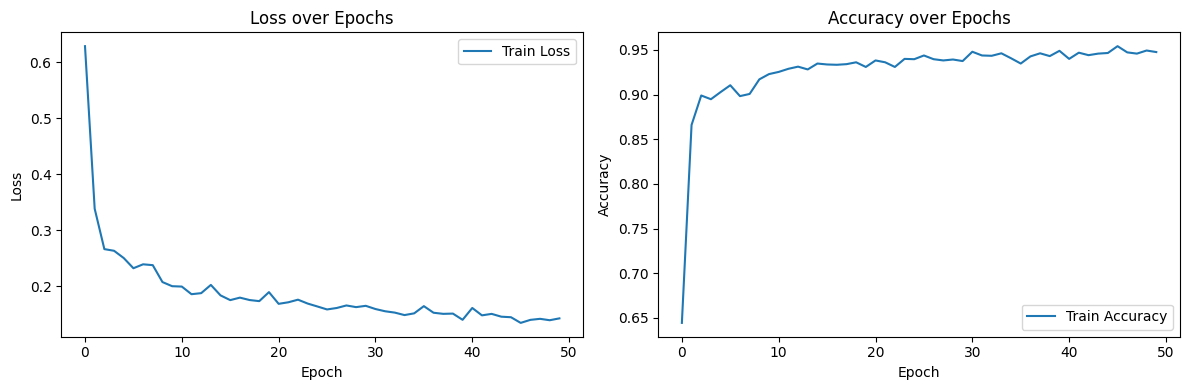

In [56]:
plot_training_history(lstm_history)


============= Test Results =============
Overall Accuracy: 90.71%

Classification Report:
              precision    recall  f1-score   support

           0     0.8608    0.9786    0.9159       373
           1     0.9731    0.8305    0.8961       348

    accuracy                         0.9071       721
   macro avg     0.9170    0.9045    0.9060       721
weighted avg     0.9150    0.9071    0.9064       721



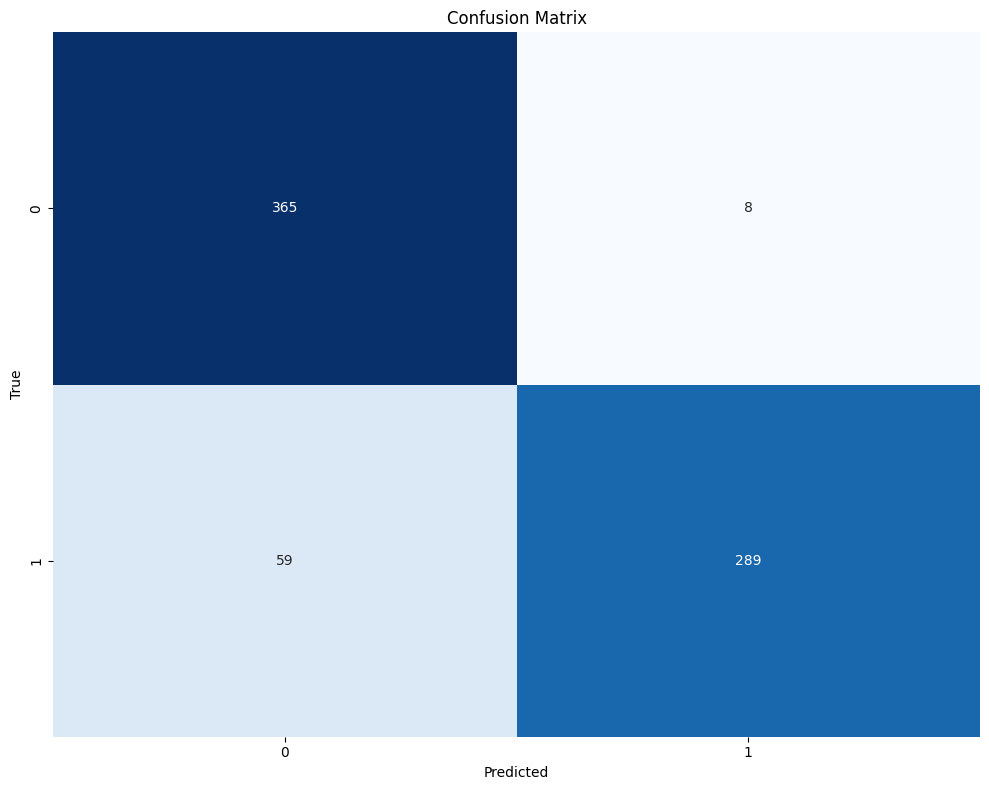

In [57]:
lstm_metrics = evaluate_model(lstm_model, test_loader, device, class_names)

#### CNN


In [58]:
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(CNNModel, self).__init__()

        # First Conv block
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Second Conv block
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        # Calculate size after convolutions and pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Input shape: [batch, 1, sequence_length]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [59]:
X_train_tensor = X_train_tensor.squeeze().unsqueeze(1)  # [batch_size, 1, sequence_length]
X_test_tensor = X_test_tensor.squeeze().unsqueeze(1)
X_test_tensor = X_test_tensor.squeeze().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Final X_train_tensor shape:", X_train_tensor.shape)

Final X_train_tensor shape: torch.Size([2880, 1, 500])


In [60]:
model = CNNModel(input_channels=1, num_classes=num_classes).to(device)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
cnn_model, cnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.5635 |    69.06% | ✓
  2/50  |     0.4054 |    82.01% | ✓
  3/50  |     0.3439 |    84.62% | ✓
  4/50  |     0.3075 |    86.63% | ✓
  5/50  |     0.2848 |    87.19% | ✓
  6/50  |     0.2637 |    89.34% | ✓
  7/50  |     0.2553 |    89.62% | ✓
  8/50  |     0.2560 |    89.76% | ✓
  9/50  |     0.2343 |    89.93% | ✓
 10/50  |     0.2460 |    89.48% | 
 11/50  |     0.2388 |    89.76% | 
 12/50  |     0.2386 |    89.83% | 
 13/50  |     0.2344 |    90.10% | ✓
 14/50  |     0.2403 |    89.41% | 
 15/50  |     0.2166 |    90.76% | ✓
 16/50  |     0.2262 |    90.80% | ✓
 17/50  |     0.2365 |    90.35% | 
 18/50  |     0.2292 |    90.76% | 
 19/50  |     0.2167 |    90.97% | ✓
 20/50  |     0.2203 |    90.83% | 
 21/50  |     0.2347 |    90.56% | 
 22/50  |     0.2187 |    90.94% | 
 23/50  |     0.2153 |    91.46% | ✓
 24/50  |     0.1970 |    91.77% | ✓
 25/50  |     0.2010

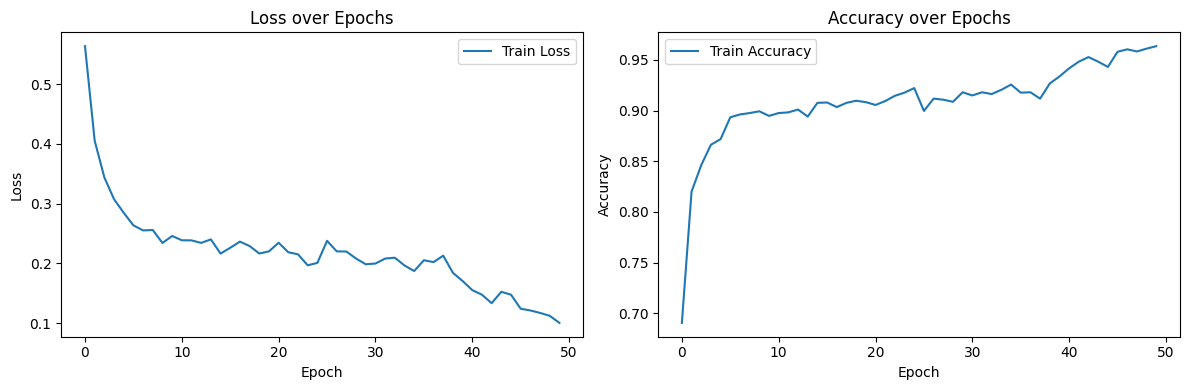

In [63]:
plot_training_history(cnn_history)


============= Test Results =============
Overall Accuracy: 73.93%

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.4960    0.6631       373
           1     0.6493    1.0000    0.7873       348

    accuracy                         0.7393       721
   macro avg     0.8246    0.7480    0.7252       721
weighted avg     0.8307    0.7393    0.7231       721



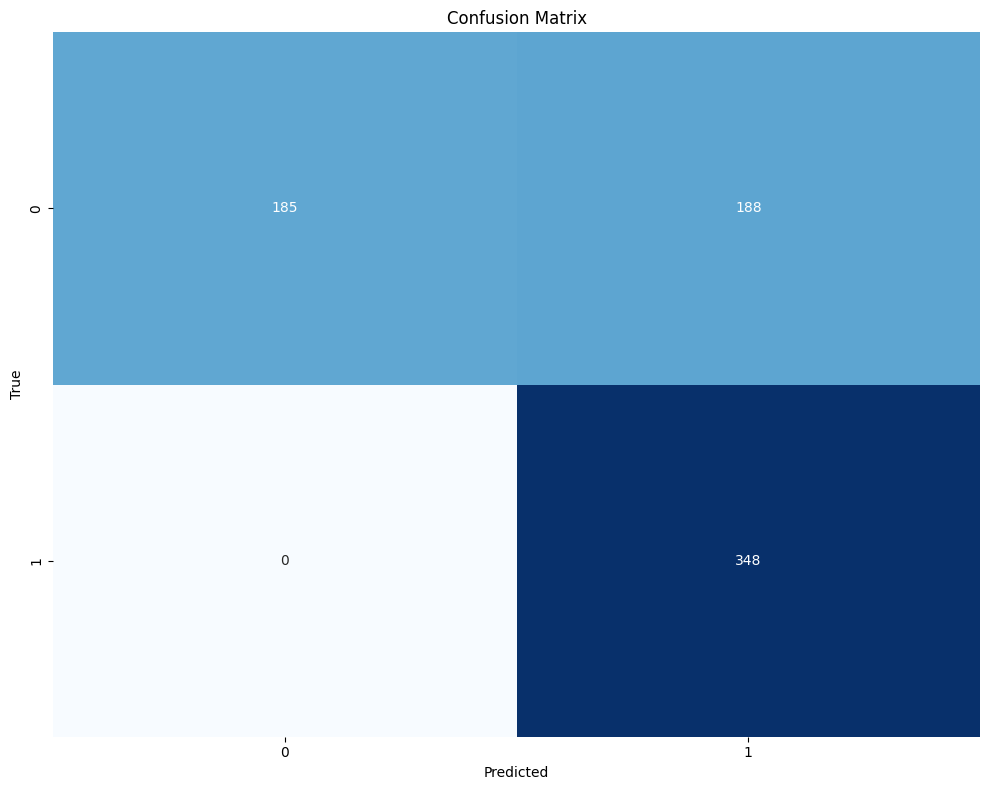

In [64]:
cnn_metrics = evaluate_model(cnn_model, test_loader, device, class_names)

# Výsledky


## Porovnání výsledků klasických metod


In [65]:
classic_results = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        classification_report(Y_test, y_test_predictions_dt, output_dict=True)['accuracy'],
        classification_report(Y_test, y_test_predictions_rf, output_dict=True)['accuracy'],
        classification_report(Y_test, y_test_predictions_gb, output_dict=True)['accuracy']
    ]
}

results_classic = pd.DataFrame(classic_results)
results_classic = results_classic.set_index('Model')

In [66]:
results_classic

,Accuracy
Model,
Decision Tree,0.579750
Random Forest,0.712899
Gradient Boosting,0.622746


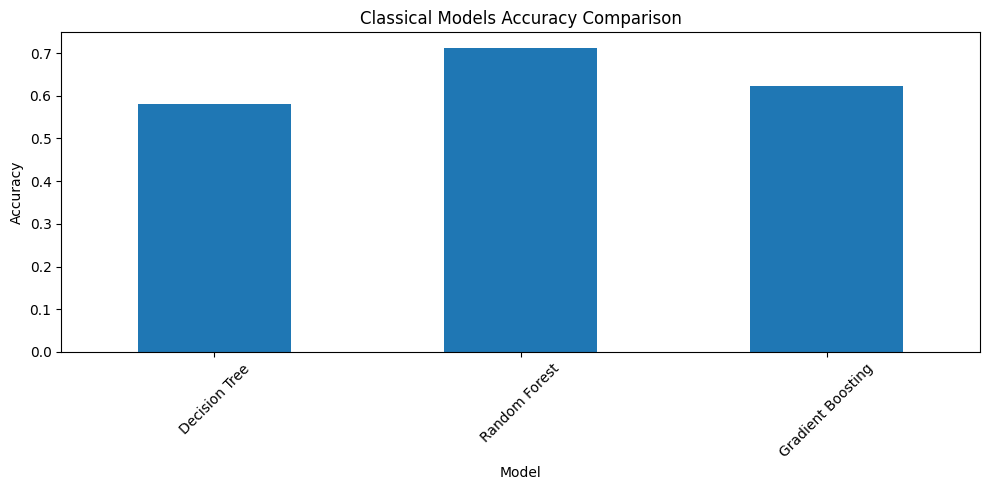

In [67]:
plt.figure(figsize=(10, 5))
results_classic['Accuracy'].plot(kind='bar')
plt.title('Classical Models Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Porovnání výsledků neuronových sítí


In [68]:
nn_results = {
    'Model': ['RNN', 'GRU', 'LSTM', 'CNN'],
    'Accuracy': [
        rnn_metrics['Accuracy'],
        gru_metrics['Accuracy'],
        lstm_metrics['Accuracy'],
        cnn_metrics['Accuracy']
    ],
    'Precision': [
        rnn_metrics['Precision'],
        gru_metrics['Precision'],
        lstm_metrics['Precision'],
        cnn_metrics['Precision']
    ],
    'Recall': [
        rnn_metrics['Recall'],
        gru_metrics['Recall'],
        lstm_metrics['Recall'],
        cnn_metrics['Recall']
    ],
    'F1-score': [
        rnn_metrics['F1-score'],
        gru_metrics['F1-score'],
        lstm_metrics['F1-score'],
        cnn_metrics['F1-score']
    ]
}

In [69]:
results_nn = pd.DataFrame(nn_results)
results_nn = results_nn.set_index('Model')

<Figure size 1200x600 with 0 Axes>

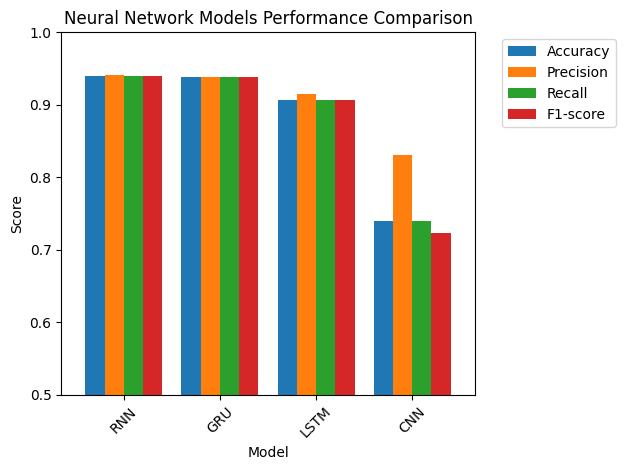

In [76]:
# Plot the results
plt.figure(figsize=(12, 6))
results_nn.plot(kind='bar', width=0.8)
plt.title('Neural Network Models Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)  # Set y-axis minimum to 0.95
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [71]:
results_nn

,Accuracy,Precision,Recall,F1-score
Model,,,,
RNN,0.940361,0.941693,0.940361,0.940374
GRU,0.938974,0.938974,0.938974,0.938974
LSTM,0.907074,0.915011,0.907074,0.906373
CNN,0.739251,0.830708,0.739251,0.723052
